# [관련 깃헙](https://github.com/kairess/license_plate_recognition/blob/master/main.ipynb)
# [유투브](https://www.youtube.com/watch?v=PpTl7xxGXh4)

(150, 200, 3)


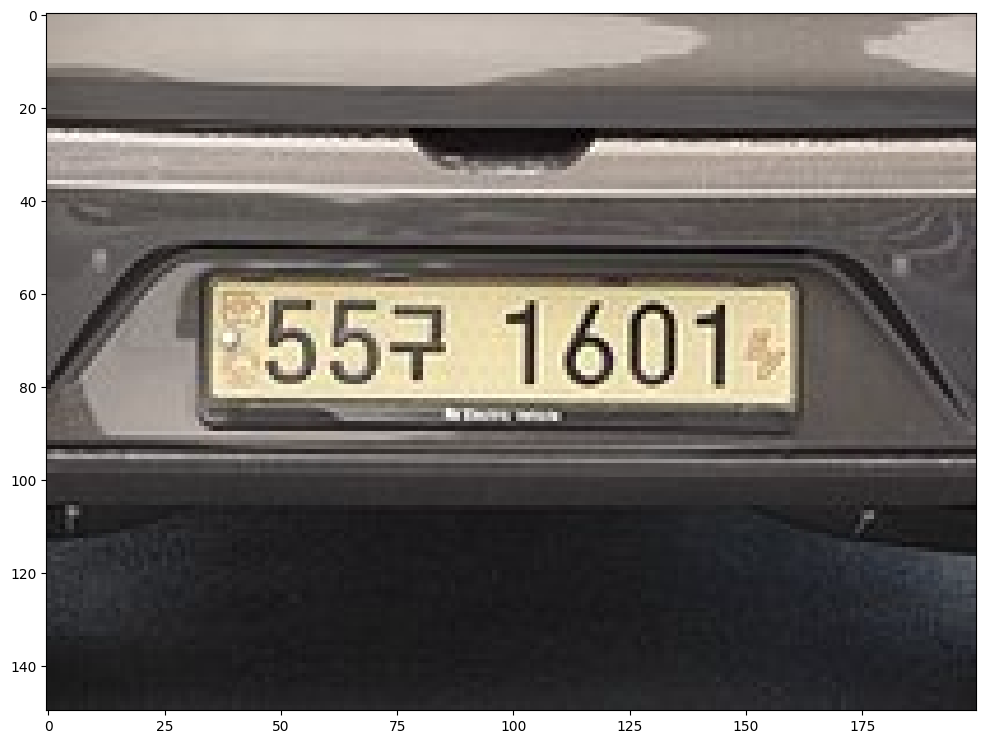

In [53]:
import easyocr
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import cv2

img_ori = cv2.imread('plate2.jpg')

height, width, channel = img_ori.shape

print(img_ori.shape)

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')

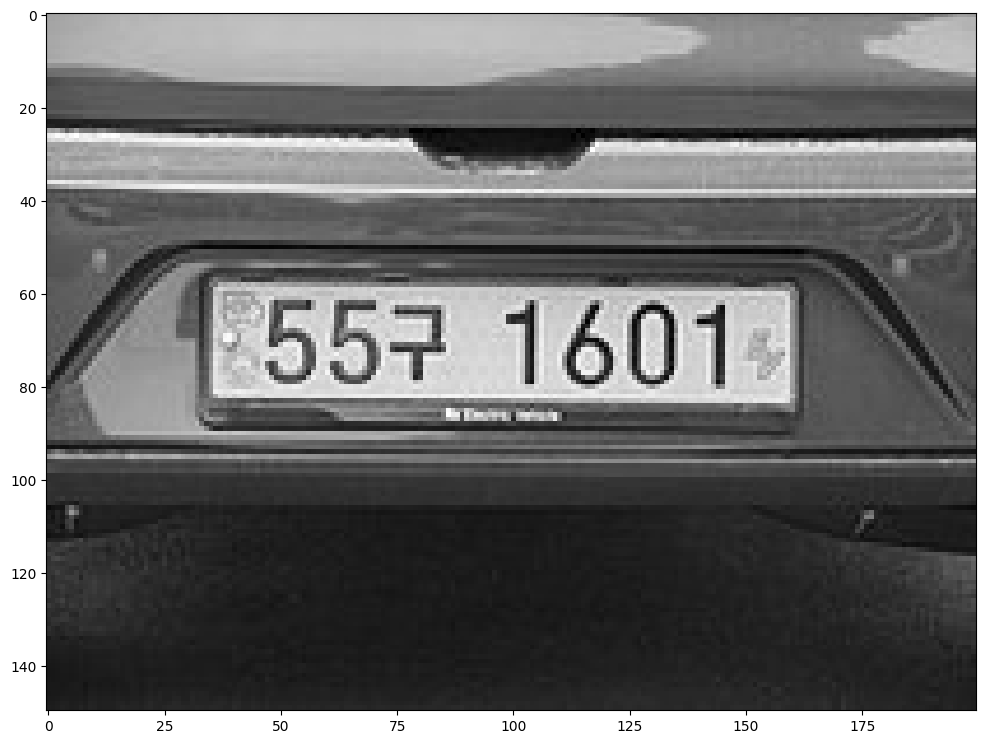

In [54]:
# gray scale로 바꿔주기
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

Adaptive Thresholding

In [55]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5,5), sigmaX=0)

img_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)

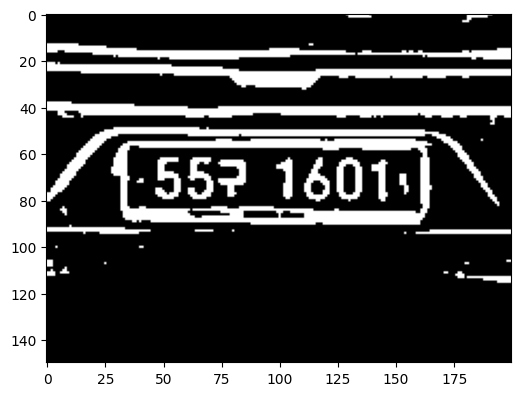

In [56]:
plt.figure(figsize=(6, 5))
plt.imshow(img_thresh, cmap='gray')

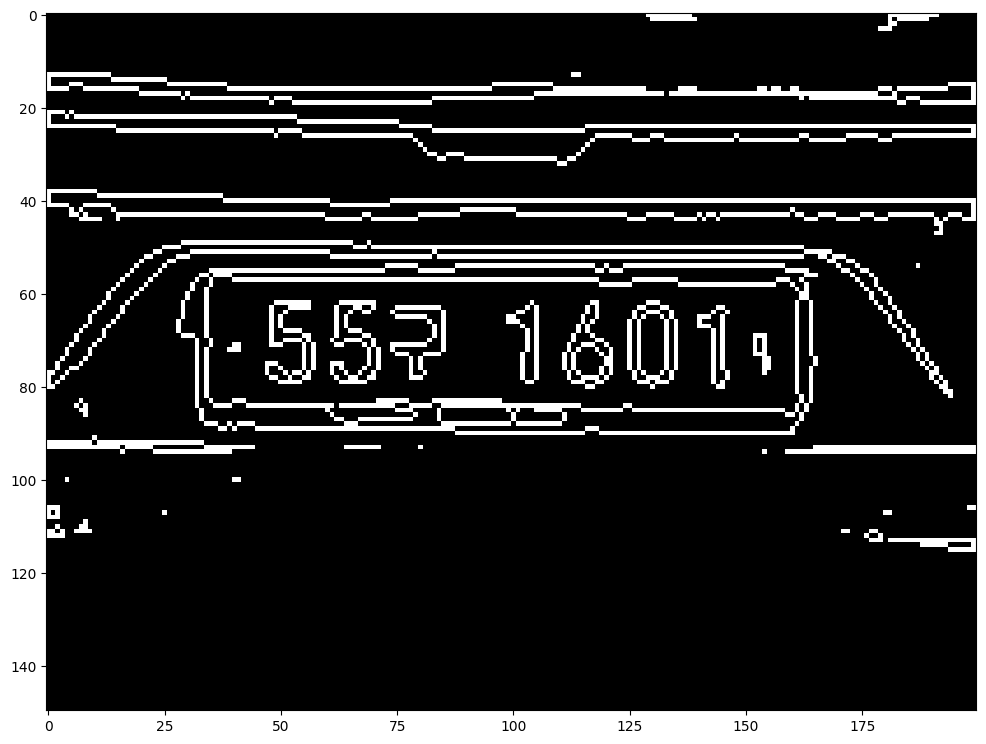

In [57]:
# ValueError: not enough values to unpack (expected 3, got 2) 에러
# OpenCV 버전에 따라 cv2.findContours 함수의 반환값이 변경되었기 때문
# OpenCV 4.x 버전 이상에서는 반환값으로 윤곽선 리스트(contours)와 계층 정보(hierarchy)만을 반환하며, 세 번째 인자인 contours 수준(depths)은 제공하지 않음
contours, _ = cv2.findContours(
    img_thresh,
    mode= cv2.RETR_LIST,
    method=cv2.CHAIN_APPROX_SIMPLE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)


# idx에 -1을 주면 전체 윤곽선을 다 그리겠다는 뜻
cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

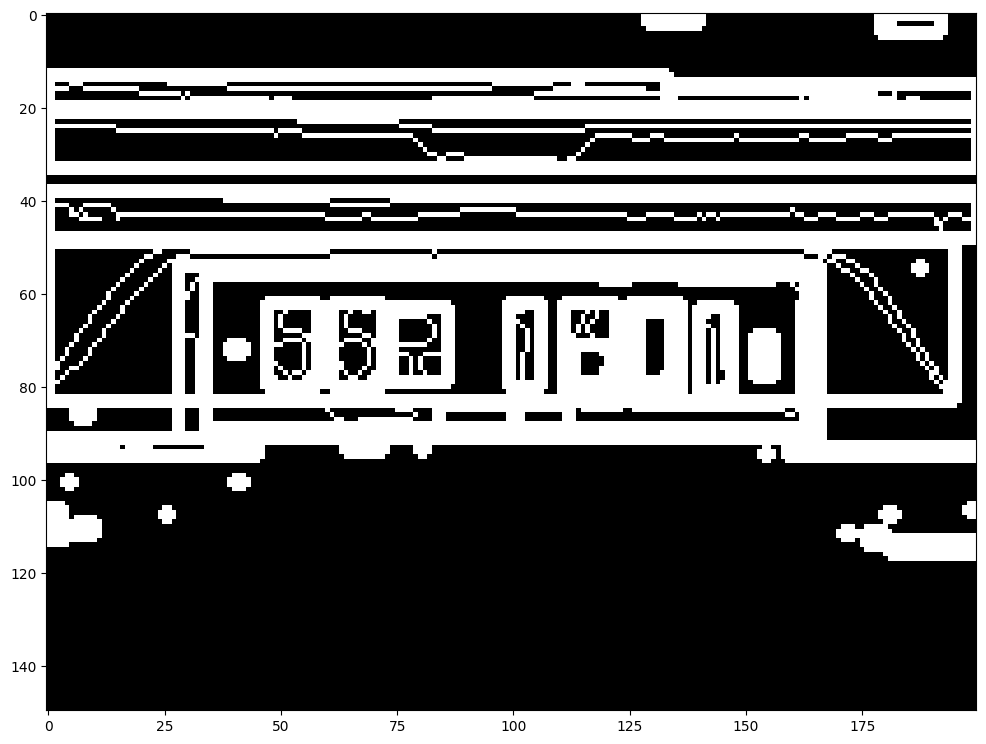

In [58]:
# 번호판의 위치를 찾기 쉽도록
contours_dict = []

for contour in contours:
    # boundingRect -> 윤곽선을 감싸는 사각형을 구함
    x, y, w, h = cv2.boundingRect(contour)
    # 바운딩을 그려주기
    cv2.rectangle(temp_result, pt1 = (x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # dict 넣어주기
    contours_dict.append({
        'contour':contour,
        'x': x,
        'y': y,
        'w' : w,
        'h': h,
        'cx': x +(w /2),
        'cy': y + (h /2)
    })
    
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

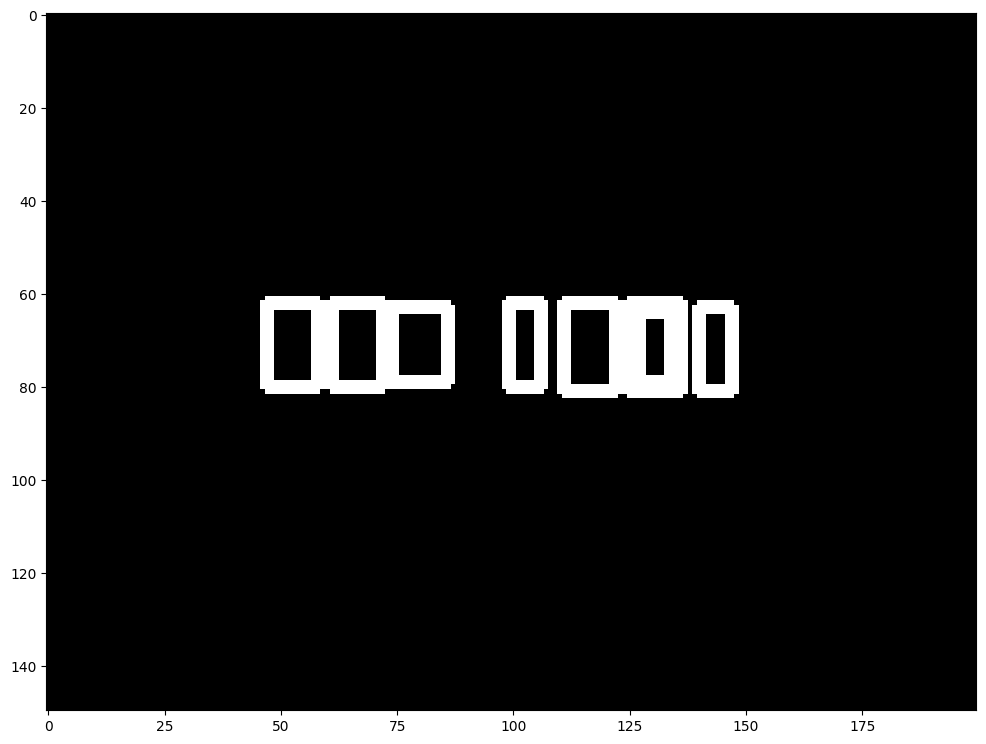

In [59]:
# 번호판 처럼 생긴 애들만 남겨주기

MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# possible contours 보여주기
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    # 바운딩을 그려주기
    cv2.rectangle(temp_result, pt1 = (d['x'], d['y']), pt2=(d['x'] + d['w'], d['y'] + d['h'] ), color=(255, 255, 255), thickness=2)
    
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

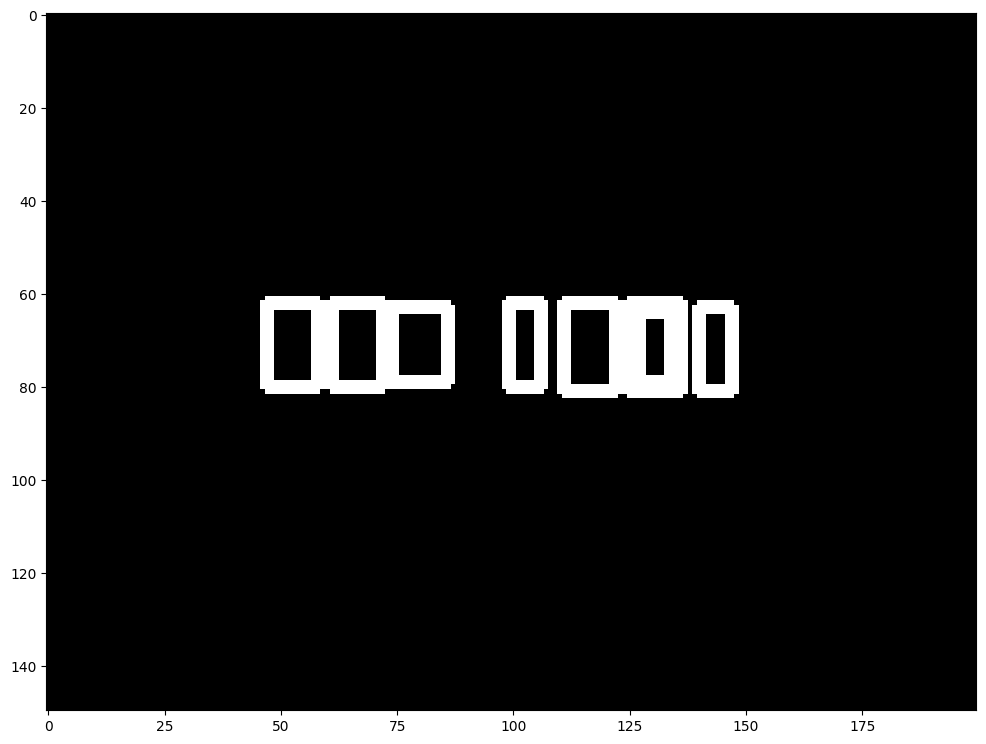

In [60]:
# 사각형의 대각선 5배 길이 안에 있어야 한다
MAX_DIAG_MULTIPLYER = 5

# 첫번째 컨투어랑 두번째 컨투어의 중심을 이었을때의 앵글의 최댓값
MAX_ANGLE_DIFF = 12.0

# 면적의 차이
MAX_AREA_DIFF = 0.5

# 너비 차이
MAX_WIDTH_DIFF = 0.8

# 높이 차이
MAX_HEIGHT_DIFF = 0.2

# 번호판 같은 애들을 뽑았는데 n개 미만이면 이 그룹은 제외 할것
MIN_N_MATCHED = 3

# 재귀함수로 반복해서 찾을것이기 때문에 함수로 지정
def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_dix = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue
            
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
            
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            
            if dx ==0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy/ dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']
            
            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF\
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_dix.append(d2['idx'])
                
        # append
        matched_contours_dix.append(d1['idx'])
        
        if len(matched_contours_dix) < MIN_N_MATCHED:
            continue
        
        matched_result_idx.append(matched_contours_dix)
        
        # 일치 하지 않은 애들도 한번더 확인
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_dix:
                unmatched_contour_idx.append(d4['idx'])
                
        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
            
        break
    
    return matched_result_idx

result_idx = find_chars(possible_contours)

matched_result = []

for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))
    
#possible conturs 보여주기
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        # 그리기
        cv2.rectangle(temp_result, pt1 = (d['x'], d['y']), pt2=(d['x'] + d['w'], d['y'] + d['h'] ), color=(255, 255, 255), thickness=2)
        
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# 삐뚫어진 번호판을 돌려주기

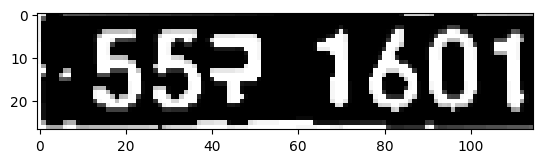

In [61]:
PLATE_WIDTH_PADDING = 1.3 # 1.3
PLATE_HEIGHT_PADDING = 1.5 # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )
    
    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
    
    # rotation matrix를 통해 이미지를 돌려준다
    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
    
    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))
    
    
    # 이미지를 잘라준다
    img_cropped = cv2.getRectSubPix(
        img_rotated, 
        patchSize=(int(plate_width), int(plate_height)), 
        center=(int(plate_cx), int(plate_cy))
    )
    
    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue
    
    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    
    plt.subplot(len(matched_result), 1, i+1)
    plt.imshow(img_cropped, cmap='gray')

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


55구 1601


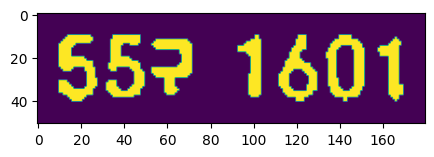

In [65]:
longest_idx, longest_text = -1, 0
plate_chars = []

for i, plate_img in enumerate(plate_imgs):
    plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
    _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # find contours again (same as above)
    contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
    
    plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
    plate_max_x, plate_max_y = 0, 0

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        
        area = w * h
        ratio = w / h

        if area > MIN_AREA \
        and w > MIN_WIDTH and h > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            if x < plate_min_x:
                plate_min_x = x
            if y < plate_min_y:
                plate_min_y = y
            if x + w > plate_max_x:
                plate_max_x = x + w
            if y + h > plate_max_y:
                plate_max_y = y + h
                
    img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
    
    img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
    _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # 검정색으로 패딩을 준다
    img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

    plt.figure(figsize=(5,3))
    plt.imshow(img_result)
    # 테서렉트 사용
    reader = easyocr.Reader(lang_list=['ko'])
    chars = reader.readtext(img_result)
    
    chars = chars[0][1]
    print(chars)


55구 1601


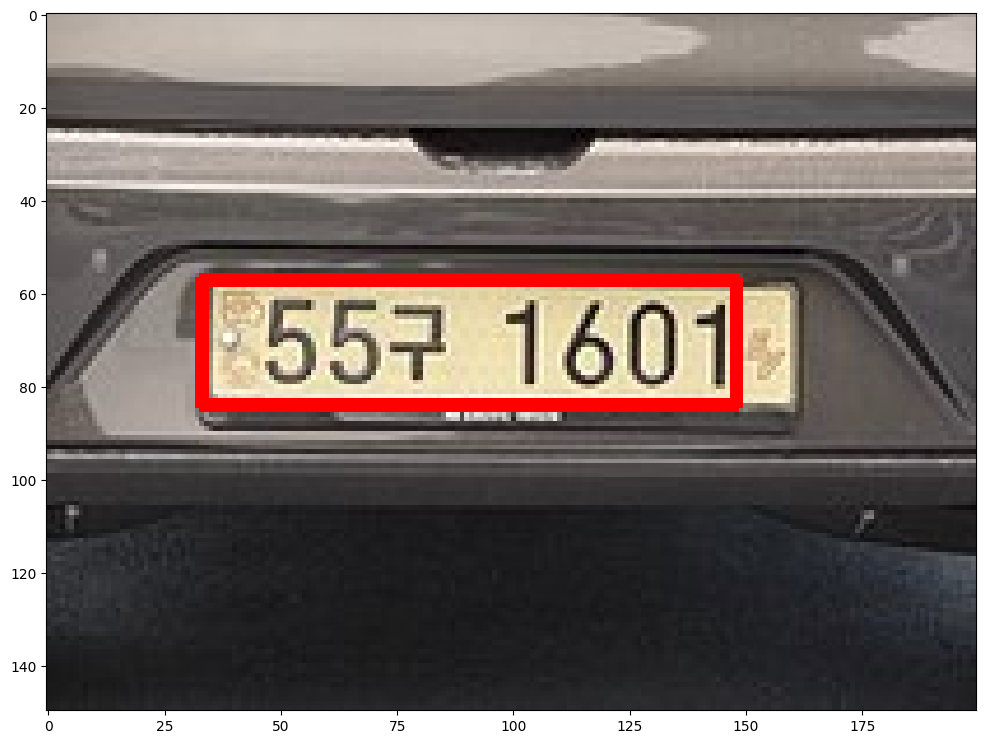

In [67]:
info = plate_infos[longest_idx]

print(chars)

img_out = img_ori.copy()

cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

cv2.imwrite(chars + '.jpg', img_out)

plt.figure(figsize=(12, 10))
plt.imshow(img_out)